In [31]:
# 1. Import thư viện cần thiết
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [32]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('ETH-USD.csv')
df1=df.reset_index()['Close']

In [33]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [34]:
# 4. Chia train test 
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [35]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [36]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [37]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [38]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [39]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 2s 48ms/step - loss: 0.0069 - val_loss: 8.2373e-04
Epoch 2/100
16/16 [==============================] - 1s 42ms/step - loss: 9.7856e-04 - val_loss: 0.0011
Epoch 3/100
16/16 [==============================] - 1s 45ms/step - loss: 6.8214e-04 - val_loss: 0.0013
Epoch 4/100
16/16 [==============================] - 1s 46ms/step - loss: 6.8462e-04 - val_loss: 9.3971e-04
Epoch 5/100
16/16 [==============================] - 1s 44ms/step - loss: 6.2254e-04 - val_loss: 6.9016e-04
Epoch 6/100
16/16 [==============================] - 0s 25ms/step - loss: 6.0300e-04 - val_loss: 9.2124e-04
Epoch 7/100
16/16 [==============================] - 0s 26ms/step - loss: 6.0051e-04 - val_loss: 8.8234e-04
Epoch 8/100
16/16 [==============================] - 0s 27ms/step - loss: 6.0997e-04 - val_loss: 6.2958e-04
Epoch 9/100
16/16 [==============================] - 0s 24ms/step - loss: 5.5720e-04 - val_loss: 7.1965e-04
Epoch 10/100
16/16 [====================

In [40]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 10ms/step


In [41]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [42]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 1644.3381912313193
Testing RMSE: 1936.4638446837014


In [43]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
r_squared = r2_score(ytest, y_pred)
print("Test_R-squared: ", r_squared) 
r_squared = r2_score(yval, y_pred_val)
print("Val_R-squared: ", r_squared) 

test_mape = mean_absolute_percentage_error(ytest, y_pred)
print("Testing MAPE",test_mape)
val_mape = mean_absolute_percentage_error(yval, y_pred_val)
print("Validation MAPE",val_mape)

Test_R-squared:  -195469179.40196604
Val_R-squared:  -6618848446.52788
Testing MAPE 5064.172555222049
Validation MAPE 5011.853470181279


In [44]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=96
i=0
while(i<30):
    
    if(len(temp_input)>96):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.36249894]
97
1 day input [0.23542094 0.23057648 0.23304257 0.23254071 0.23201781 0.23290864
 0.23581711 0.23584306 0.24471132 0.24341808 0.24744149 0.24635629
 0.25126099 0.25852154 0.26171792 0.27262522 0.27899918 0.28615287
 0.30720246 0.307579   0.3127524  0.31084324 0.29972513 0.30759537
 0.33036678 0.3234341  0.32370258 0.32367476 0.3084552  0.32016125
 0.31833331 0.31728193 0.31181806 0.32747813 0.31073288 0.31481332
 0.32655134 0.32685911 0.33142709 0.33191856 0.32439589 0.32112481
 0.33296886 0.32844703 0.30629569 0.29958964 0.3049125  0.29962459
 0.29795328 0.30851275 0.33333899 0.32618488 0.33780784 0.33717825
 0.33497258 0.33948427 0.33000189 0.32685701 0.32852288 0.3194522
 0.31659333 0.3263441  0.32496531 0.3189258  0.33114841 0.32772532
 0.31112397 0.31064736 0.31012582 0.31074821 0.30958719 0.30367225
 0.2834011  0.2813825  0.29273843 0.31561152 0.33473313 0.33966098
 0.32960766 0.334076   0.35856211 0.35201403 0.35709456 0.34641911
 0.3615946  0.34692802 0.36364331 0

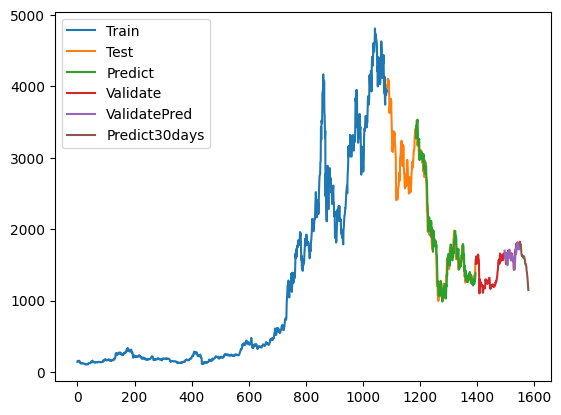

In [45]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()